# Начало работы

**Задача:** предсказать стоимость жилья по имеющимся данным

Датасет взят с платформы kaggle: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

В процессе работы был проведен подробный разведочный анализ, оценено влияние признаков на целевую переменную, взаимосвязь признаков между собой, неинформативные были отброшены.

В качестве модели использовалась Ридж-регрессия

Точность предсказания вышла около 90%

При работе был в том чисте использован ноутбук https://www.kaggle.com/code/adibouayjan/house-price-step-by-step-modeling#IV.-Modeling

## Подключение библиотек

In [208]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

from scipy import stats
from scipy.stats import chi2_contingency

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={"figure.figsize": (20, 20)})
sns.set_style("whitegrid")

## Функции и переменные

In [113]:

def add_into_list(list_el, new_el):
    """
    Функция добавления списка элементов в массив
    """
    if np.isin(new_el, list_el).sum() == 0:
        return np.append(list_el, new_el)
    else:
        return list_el
    


def del_from_list(list_el, new_el):
    """
    Функция удаления элементов из массива
    """
    if np.isin(new_el, list_el).sum():
        return np.setdiff1d(list_el, new_el)
    else:
        return list_el
    
def exp(y: np.ndarray) -> np.ndarray:
    """
    Потенционирование (обратное логарифмирование) 
    """
    return np.exp(y) - 1
    
RANDOM_STATE = 100
SPLIT_TEST_SIZE = 0.2 # размер тестовой выборки
NUM_SPLIT_FOR_GRID = 5 #на сколько частей будет разбиваться выборка при подборе параметров
TRESHOLD_FOR_CORR = 0.1 #порог значения корреляции, ниже которого будем отбрасывать признаки
TRESHOLD_FOR_HIGH_CORR = 0.6 #при этом пороге корреляции будем тщательнее исследовать на предмет выбросов
TRESHOLD_FOR_HIGH_CORR_BETWEEN_FEATURE = 0.8 #если корреляция выше - удаляемм один из коррелируемых признаков 

## Загрузка данных

In [114]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
#запомним id тестовой - он нужен для загрузки в kaggle, но при анализе удалится ввиду неинформативности для модели 
test_id = test.Id
test_id.head()


0    1461
1    1462
2    1463
3    1464
4    1465
Name: Id, dtype: int64

# Основная информация о данных

In [115]:
print(train.shape)
print(test.shape)


(1460, 81)
(1459, 80)


т.к. объектов меньше 10000, лучше не прибегать к сложным моделям типа бустинга 

In [116]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

видим большое кол-во пропущенных значений в колонках Alley,FireplaceQu, PoolQC, Fence, MiscFeature. Надо разобраться, сильно ли их значения влияют на целевую переменную, если нет - то удалить. Так же имеются значения с небольшим количеством пропущенных значений - заполнить их. Все это будем делать при детальном анализе числовых и категориальных переменных.

Много признаков object - нужно проанализировать их значения, может какие то из них numeric - изучим при анализе типов данных.

# Анализ целевой переменной

In [117]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Видим, что распределение целевой переменной не нормальное, сильный перекос вправо: очень большая разница между max и 3ьим квантилем

Text(0.5, 0.98, 'Распределение целевой переменной SalePrice')

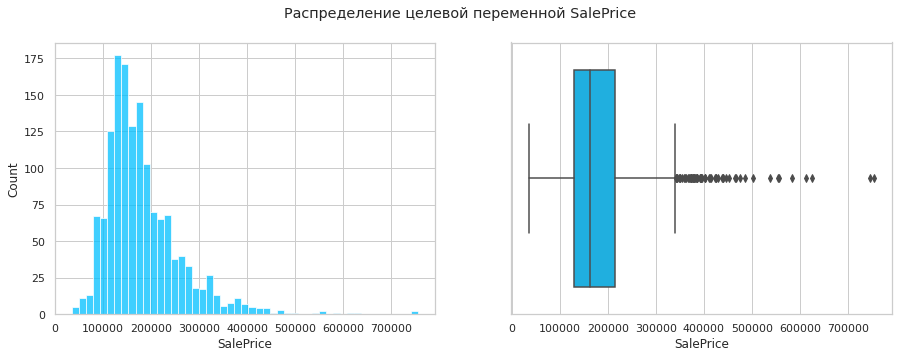

In [118]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.histplot(data=train, x='SalePrice', ax=axis[0], color="deepskyblue")
sns.boxplot(data=train, x='SalePrice', ax=axis[1], color="deepskyblue")
plt.suptitle('Распределение целевой переменной SalePrice')

In [119]:
print(stats.shapiro(train.SalePrice))

ShapiroResult(statistic=0.869671642780304, pvalue=3.206247534576162e-33)


По графикам и тесту Шапиро видно, что распределение далеко от нормального, попробуем привести его логарифмированием

In [120]:
train['SalePriceLog'] = np.log(train.SalePrice + 1)
print(stats.shapiro(train.SalePriceLog))

ShapiroResult(statistic=0.9912054538726807, pvalue=1.1467612637261482e-07)


Text(0.5, 0.98, 'Распределение целевой переменной SalePriceLog')

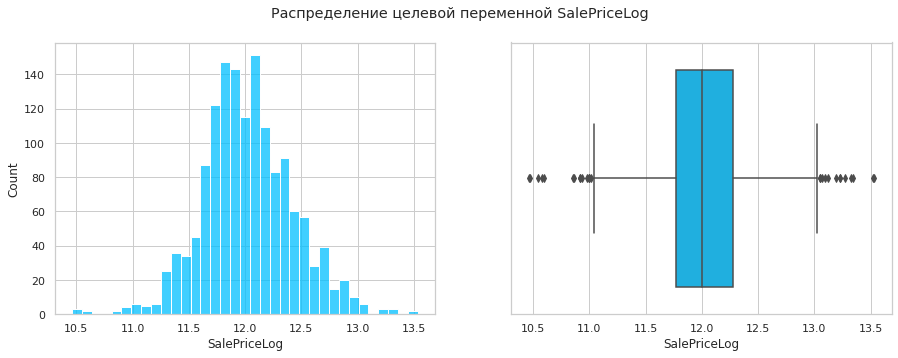

In [121]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.histplot(data=train, x='SalePriceLog', ax=axis[0], color="deepskyblue")
sns.boxplot(data=train, x='SalePriceLog', ax=axis[1], color="deepskyblue")
plt.suptitle('Распределение целевой переменной SalePriceLog')

Логарифмирование немного помогло, попробуем еще отсечь выбросы

In [122]:
train_short = train[(train.SalePriceLog<13) & (train.SalePriceLog>11.1)]
#train_short = train_short.drop(columns=['SalePriceLog'], axis=1)
print('train_short shape:', train_short.shape)
print('train_short and train diff rows:', round(100*(train.shape[0]-train_short.shape[0])/train.shape[0],1),'%')

train_short shape: (1428, 82)
train_short and train diff rows: 2.2 %


Процент отброшенных значений не велик (<10%)

In [123]:
print(stats.shapiro(train_short.SalePriceLog))

ShapiroResult(statistic=0.9925791621208191, pvalue=1.3522821973310784e-06)


За счет удаления небольшого числа объектов, еще приблизились к нормальному распределению. На этом закончим обработку целевого признака, построив график окончательного набора данных

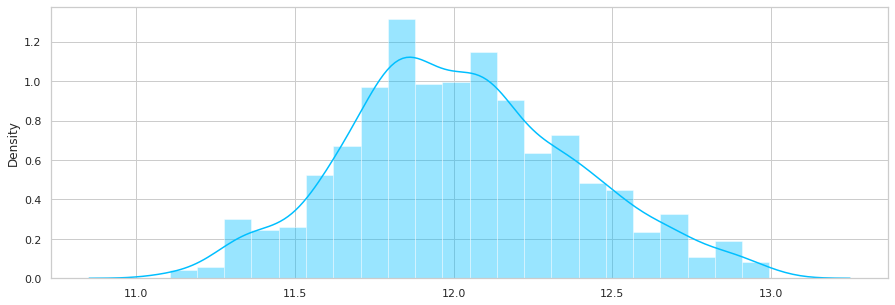

In [124]:
plt.figure(figsize=(15,5))
sns.distplot(x=train_short['SalePriceLog'], color="deepskyblue")
#и перезапишем нашу тренировочную выборку
train = train_short

# Типы данных

In [125]:
#посмотрим какие типы данных в каком количестве
train.dtypes.value_counts()

object     43
int64      35
float64     4
dtype: int64

## Категориальные признаки

In [126]:
#отбор не числовых колонок 
train_non_numeric = train.select_dtypes(exclude=[np.number])
non_numeric_cols = train_non_numeric.columns.values
print(non_numeric_cols)

['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageQual'
 'GarageCond' 'PavedDrive' 'PoolQC' 'Fence' 'MiscFeature' 'SaleType'
 'SaleCondition']


In [127]:
#должны посмотреть значения категориальных - возможно, ошибка в типе
for col in train_non_numeric:
    print(col, train[col].unique())

MSZoning ['RL' 'RM' 'FV' 'C (all)' 'RH']
Street ['Pave' 'Grvl']
Alley [nan 'Grvl' 'Pave']
LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandContour ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities ['AllPub' 'NoSeWa']
LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope ['Gtl' 'Mod' 'Sev']
Neighborhood ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
Exterior1st ['VinylSd' 'MetalSd'

со значениями все нормально, численных среди категориальных нет

<b>Посмотрим на числовые переменные</b>

## Числовые признаки

In [128]:
# отбор числовых колонок
train_numeric = train.select_dtypes(include=[np.number])
numeric_cols = train_numeric.columns.values
print(numeric_cols)

['Id' 'MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF'
 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold'
 'SalePrice' 'SalePriceLog']


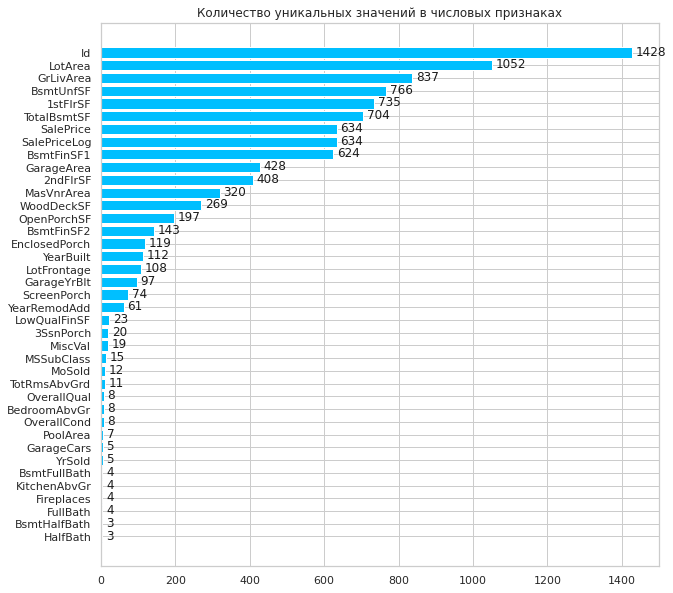

In [129]:
#нужно посмотреть нет ли среди числовых признаков на самом деле категориальных
train_numeric_count = train_numeric.nunique().sort_values()
train_numeric_count 
plt.figure(figsize=(10,10))
plt.barh(y=train_numeric_count.index, width=train_numeric_count.values, color="deepskyblue")
plt.title('Количество уникальных значений в числовых признаках')
for i, v in enumerate(train_numeric_count.values):
    plt.text(v+10, i - .2, str(v), color='k')

по графику видим, что есть некоторые признаки, которые напоминают категориальные, исследуем признаки, у которых уникальных значений <25. Нам нужно изучить что это за столбцы и определить их к категориальным, либо ранговым(в таком случае отнести их к числовым). 

Категориальные: MSSubClass, YrSold, MoSold

Порядковые: BsmtHalfBath, HalfBath, FullBath, BsmtFullBath, Fireplaces, KitchenAbvGr, GarageCars, BedroomAbvGr, PoolArea, OverallCond, OverallQual, TotRmsAbvGrd, 3SsnPorch, MiscVal, LowQualFinSF

## Модификация типов признаков

In [130]:
#изменим тип столбцов у обнаруженных категориальных переменных с int:
new_cat_col = ['MSSubClass', 'YrSold', 'MoSold']
train[new_cat_col] = train[new_cat_col].astype('object')
test[new_cat_col] = test[new_cat_col].astype('object')
#должны добавить их в массивы с категориальными колонками
non_numeric_cols = add_into_list(non_numeric_cols, new_cat_col)

#и удалить из массива с целочисленными столбцами
numeric_cols = del_from_list(numeric_cols, new_cat_col)


# Анализ категориальных переменных

## Распределение признаков

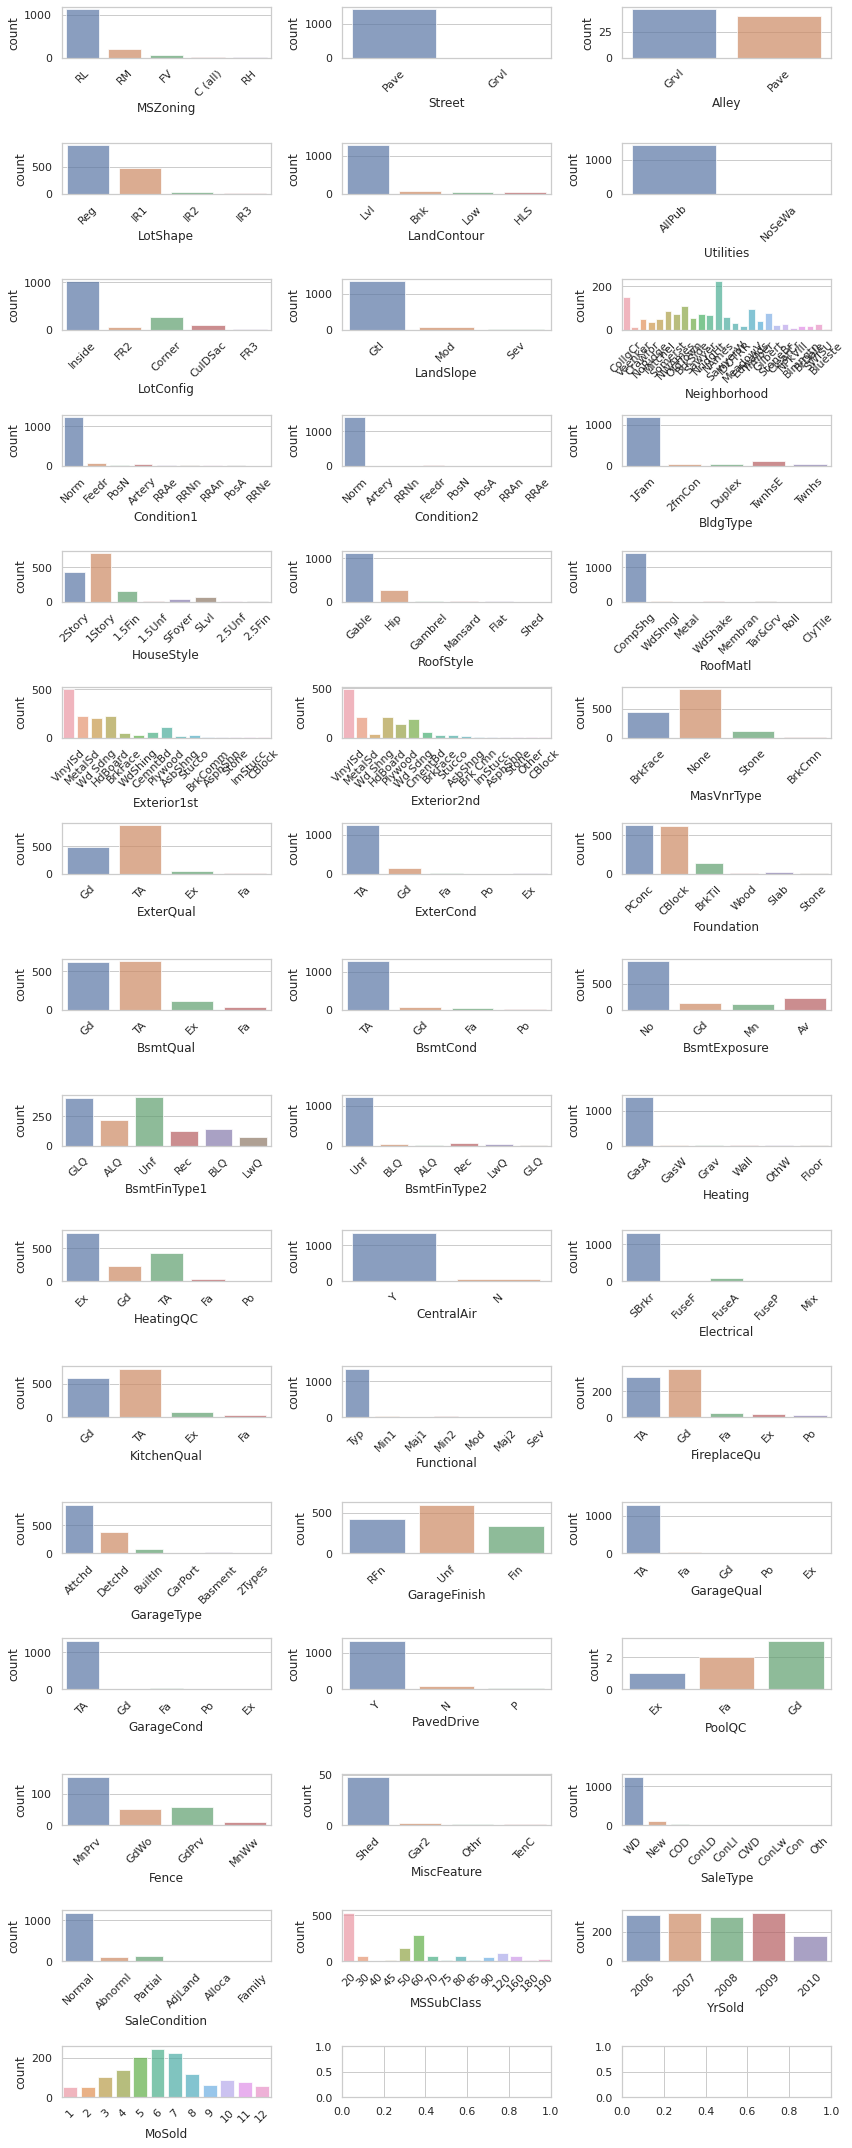

In [131]:
fig, axes = plt.subplots(
    ceil(len(train[non_numeric_cols].columns) / 3), 3, figsize=(12, 30))

for y, col in enumerate(non_numeric_cols):
    i, j = divmod(y,3)
    axes[i,j].xaxis.set_tick_params(rotation=45)
    sns.countplot(x = col, alpha=0.7, data=train[non_numeric_cols], ax=axes[i,j])
    
fig.tight_layout()


По приведенным графикам можно сделать следующие выводы: мы имеем множество признаков, сосредоточенных возле одного значения. Их нужно удалить, но прежде посмотрим влияние этих признаков на целевую. 

Это признаки: Street, LandContour, Utilities, LandSlope, Condition1, Condition2, RoofMatl, BsmtCond, BsmtFinType2, Heating, CentralAir, Electrical, Functional, GarageQual, GarageCond, MiscFeature

## Влияние слабовариативных признаков

In [132]:
#определяем признаки , сосредоточенныев основном у одного значения
ColLowVal = ['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'BsmtCond',\
             'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'MiscFeature']

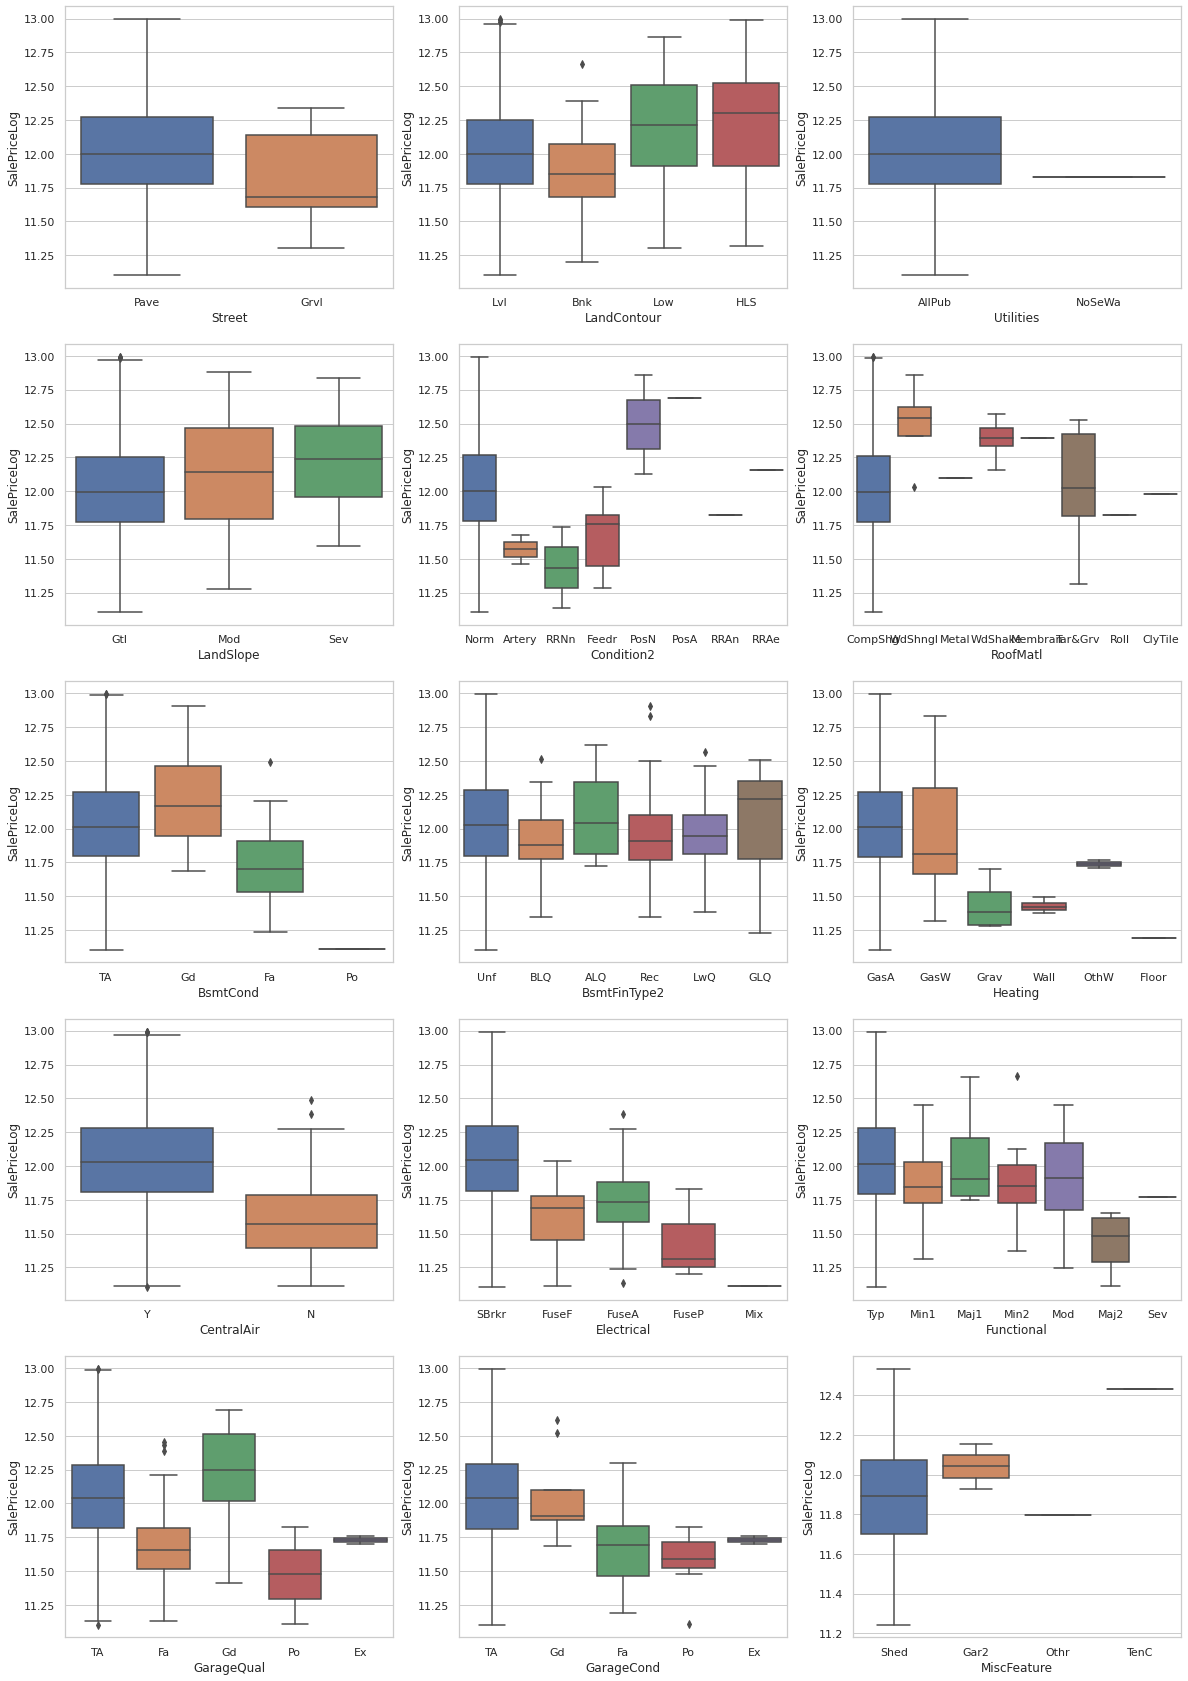

In [133]:
#теперь построим графики, демонстрирующие зависимость целевой переменной от признака с пустыми значениями
fig, ax = plt.subplots(ceil(len(ColLowVal)/3), 3, figsize=(20,30))
for y, col in enumerate(ColLowVal):
    i, j = divmod(y, 3)
    sns.boxplot(x=col, y='SalePriceLog', data=train, ax=ax[i,j])

По графикам видим, что слабовариативные признаки, которые слабо влияют на целевую, следующие:

Street', 'LandContour', 'Utilities', 'LandSlope', 'BsmtFinType2'
             
Их можно удалить из выборки.

In [134]:
ColForDel = ['Street', 'LandContour', 'Utilities', 'LandSlope', 'BsmtFinType2']

train.drop(columns=ColForDel, axis=1, inplace=True)

#и удалить из массива с категориальными столбцами
non_numeric_cols = del_from_list(non_numeric_cols, ColForDel)

Проверим, как разные значения категориальных признаков с отсутствующими значениями будут влиять на целевую переменную + <b>заменим отсутствующие значения</b>

##  Анализ зависимости целевой переменной


Посмоттрим на графики зависимости целевой переменной от различных значений категориальных признаков, на данном этапе изучим только признаки с пропущенными значениями, чтоб решить, что с ними делать.

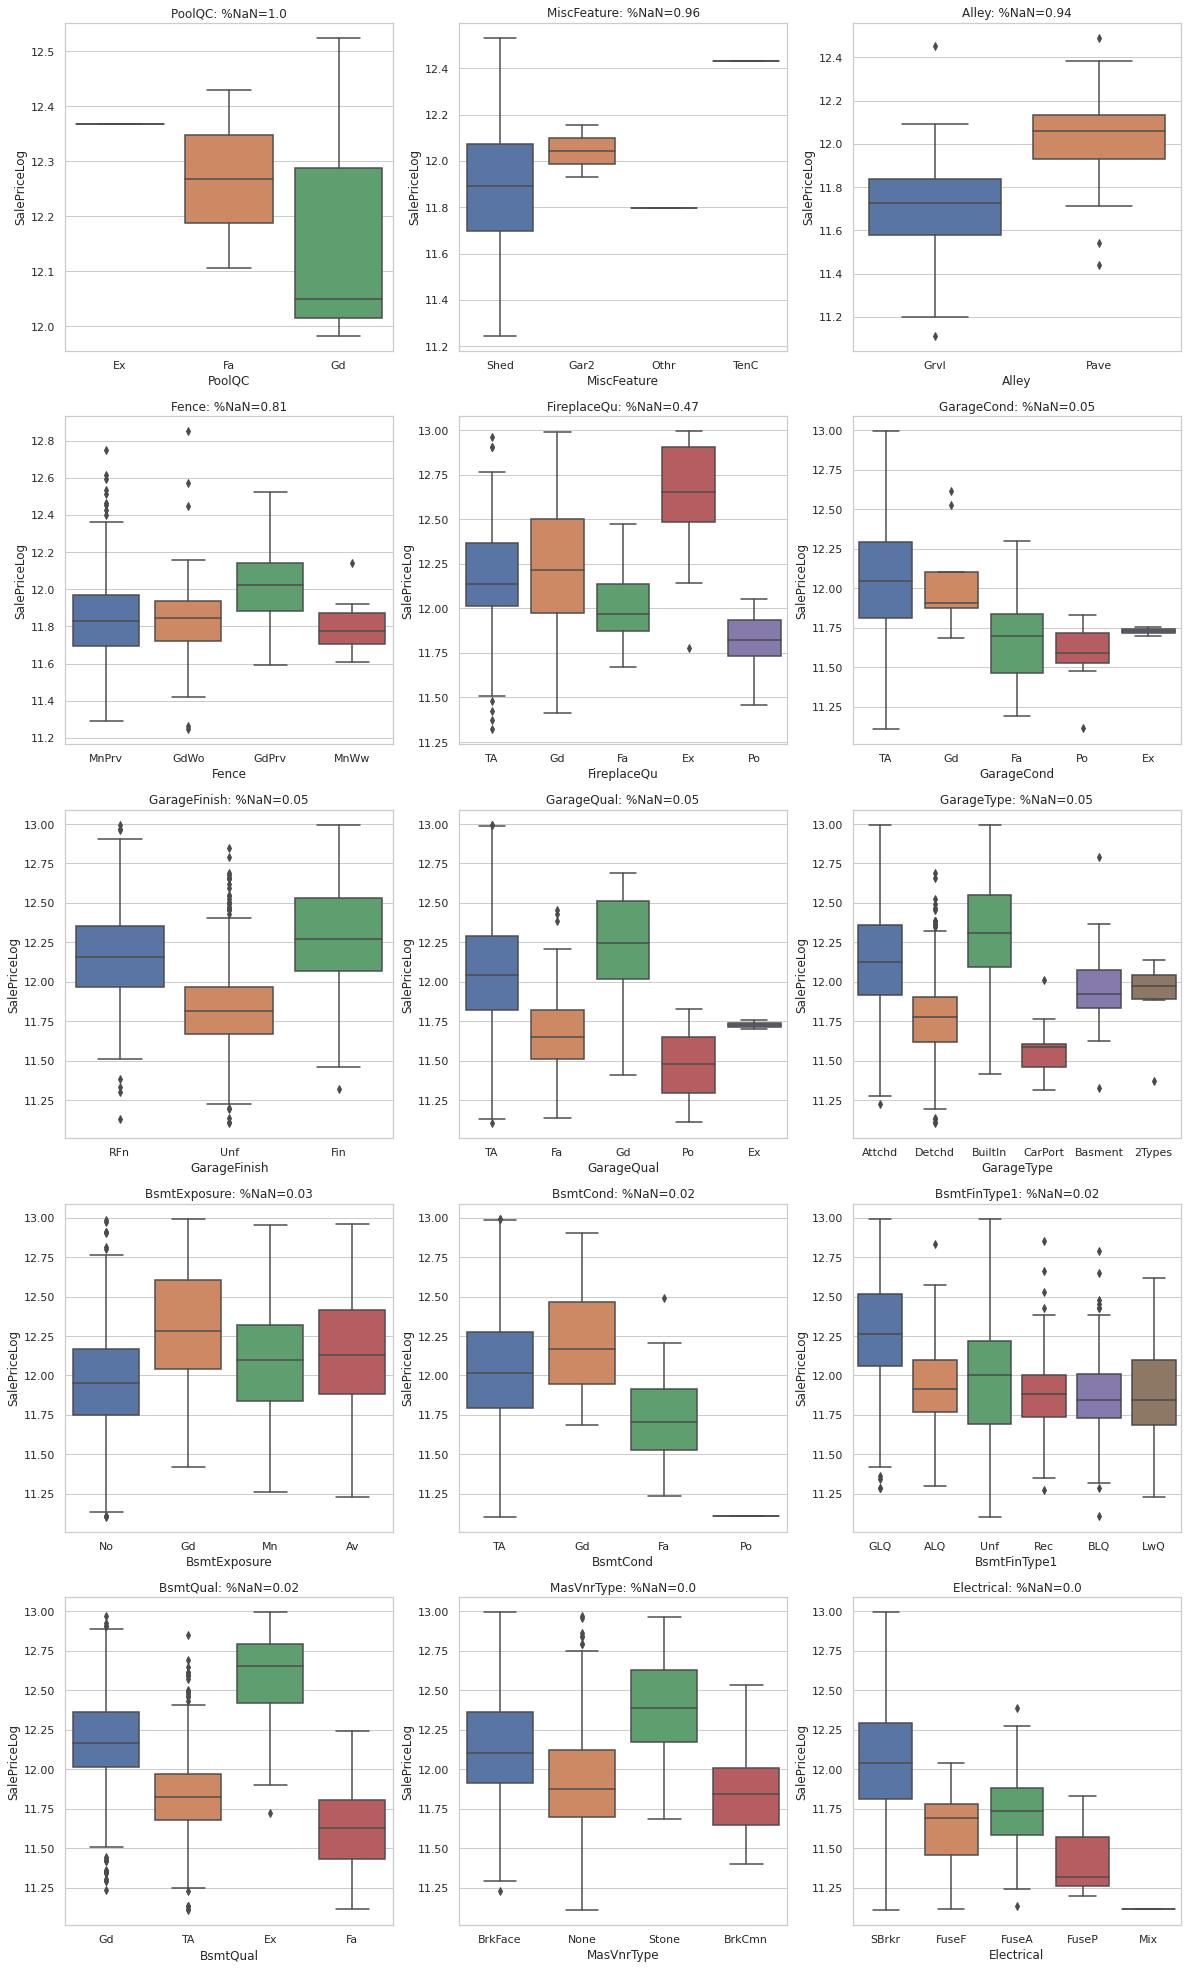

In [135]:
df_col_with_null = pd.DataFrame(columns=['col', 'num_null'])
#получаем все категорифльные перменные, в которых есть пропуски
col_all = train[non_numeric_cols].isna().sum()
col_all = col_all[col_all>0].index.to_list()

#обходим их и строим графики влияния на целевую перменную
for col in col_all:
    num_null = train[col].isna().sum()
    df_col_with_null.loc[len(df_col_with_null)] = [col, num_null]
    
#теперь построим графики, демонстрирующие зависимость целевой переменной от признака с пустыми значениями
fig, ax = plt.subplots(ceil(len(df_col_with_null)/3), 3, figsize=(20,35))
for y, el in enumerate(df_col_with_null.sort_values(by=['num_null'], ascending=False).values):
    i, j = divmod(y, 3)
    sns.boxplot(x=el[0], y='SalePriceLog', data=train, ax=ax[i,j])
    ax[i,j].set_title('' + el[0] + ': %NaN=' + str(round(el[1]/train.shape[0],2)))
    


анализ графиков и значений признаков позволил установить следующие выводы:
1. ПРизнаки, в которых лучше отсутствующие заменить на новое значение: PoolQC, MiscFeature, Alley, Fence, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, BsmtExposure, BsmtQual, BsmtCond, BsmtFinType1, MasVnrType - у данных признаков nan скорее означает отсутствие того, что обозначено в них

2. Признаки, в которых следует отсутствующие значения заменить на моду:  Electrical

3. Признаки, которые следует удалить ввиду слабой информативности:  -

## Модификация признаков с NaN

In [136]:
#меняем отсутствующие значения на ismissing
col_replace_ismissing = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', \
               'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'MasVnrType']

train[col_replace_ismissing] = train[col_replace_ismissing].fillna('ismissing') 


In [137]:
#меняем отсутствующие значения на моду
col_replace_mode = ['Electrical']
train[col_replace_mode] = train[col_replace_mode].fillna(train[col_replace_mode].mode().iloc[0])

проверим, что во всех категориальных признаках не осталось отсутствующих значений

In [138]:
train[non_numeric_cols].isna().sum()[train[non_numeric_cols].isna().sum()>0]

Series([], dtype: int64)

Ни одного категориального признака с отсутсвующими значениями


## Взаимосвязь между признаками

изучим оставшиеся признаки на предмет их взаимосвязи (χ²)

In [139]:
# Выведем оставшиеся категориальные признаки
print(non_numeric_cols)

['Alley' 'BldgType' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtQual'
 'CentralAir' 'Condition1' 'Condition2' 'Electrical' 'ExterCond'
 'ExterQual' 'Exterior1st' 'Exterior2nd' 'Fence' 'FireplaceQu'
 'Foundation' 'Functional' 'GarageCond' 'GarageFinish' 'GarageQual'
 'GarageType' 'Heating' 'HeatingQC' 'HouseStyle' 'KitchenQual' 'LotConfig'
 'LotShape' 'MSSubClass' 'MSZoning' 'MasVnrType' 'MiscFeature' 'MoSold'
 'Neighborhood' 'PavedDrive' 'PoolQC' 'RoofMatl' 'RoofStyle'
 'SaleCondition' 'SaleType' 'YrSold']


Обозначим значение переменных:

'BsmtCond' - общее состояние подвала

 'BsmtFinType1' - Оценка готовой площади подвала
 
 'ExterCond' - текущее состояние материала на внешней стороне
 
 'ExterQual' -  качество материала на внешней стороне
 
 'Exterior1st', 'Exterior2nd' - Наружное покрытие дома
 
'GarageCond' - состояние гаража

'GarageFinish' - законченность гаража

'GarageQual' - качество гаража

 'MasVnrType' - Тип облицовки каменной кладки


Можем предположить, что есть взаимосвязь между признаками: Exterior1st и Exterior2nd, BsmtCond и BsmtFinType1, ExterCond и ExterQual, GarageQual и GarageCond. Проверим нашу теорию при помощи критерия χ²


In [140]:
X = ["Exterior1st", "ExterQual", "BsmtFinType1", "GarageQual"]
Y = ["Exterior2nd", "ExterCond", "BsmtCond", "GarageCond"]

for i, j in zip(X, Y):

    CrosstabResult = pd.crosstab(
        index=train[i], columns=train[j])
    ChiSqResult = chi2_contingency(CrosstabResult)
    print(
        f"P-Value χ² теста между группами {i} и {j} = {ChiSqResult[1]}\n")
    #print(CrosstabResult)

P-Value χ² теста между группами Exterior1st и Exterior2nd = 0.0

P-Value χ² теста между группами ExterQual и ExterCond = 2.264678361098134e-08

P-Value χ² теста между группами BsmtFinType1 и BsmtCond = 1.0233626167452977e-298

P-Value χ² теста между группами GarageQual и GarageCond = 0.0



χ² тест между категориальными признаками показал, что есть сильная взаимосвязь между группами, поэтому можно оставить по одному признаку из групп зависимых, пусть это будут признаки "Exterior1st", "ExterQual", "BsmtFinType1", "GarageQual"

In [141]:
ColForDelKsi = ["Exterior1st", "ExterQual", "BsmtFinType1", "GarageQual"]
ColForDel.extend(ColForDelKsi)

train.drop(columns=ColForDelKsi, axis=1, inplace=True)

#и удалить из массива с категориальными столбцами
non_numeric_cols = del_from_list(non_numeric_cols, ColForDelKsi)

## Модификация тестовой выборки

In [142]:
test[col_replace_ismissing] = test[col_replace_ismissing].fillna('ismissing') 
test[col_replace_mode] = test[col_replace_mode].fillna(test[col_replace_mode].mode().iloc[0]) 
test.drop(columns=ColForDel, axis=1, inplace=True)

In [143]:
#проверим есть ли еще пропущенные значения в тестовой выборке, в признаках, которые в тренировочной были заполнены
test[non_numeric_cols].isna().sum()[test[non_numeric_cols].isna().sum()>0]

Exterior2nd    1
Functional     2
KitchenQual    1
MSZoning       4
SaleType       1
dtype: int64

в тестовой оказались еще признаки с пропущенными значениями, обработаем их

In [144]:
test_col_replace_mode = ['MSZoning', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType']
test[test_col_replace_mode] = test[test_col_replace_mode].fillna(test[test_col_replace_mode].mode().iloc[0])

In [145]:
test[non_numeric_cols].isna().sum()[test[non_numeric_cols].isna().sum()>0]

Series([], dtype: int64)

Мы почистили все недостающие значения в обеих выборках для категориальных переменных

# Анализ числовых переменных

## Распределение признаков

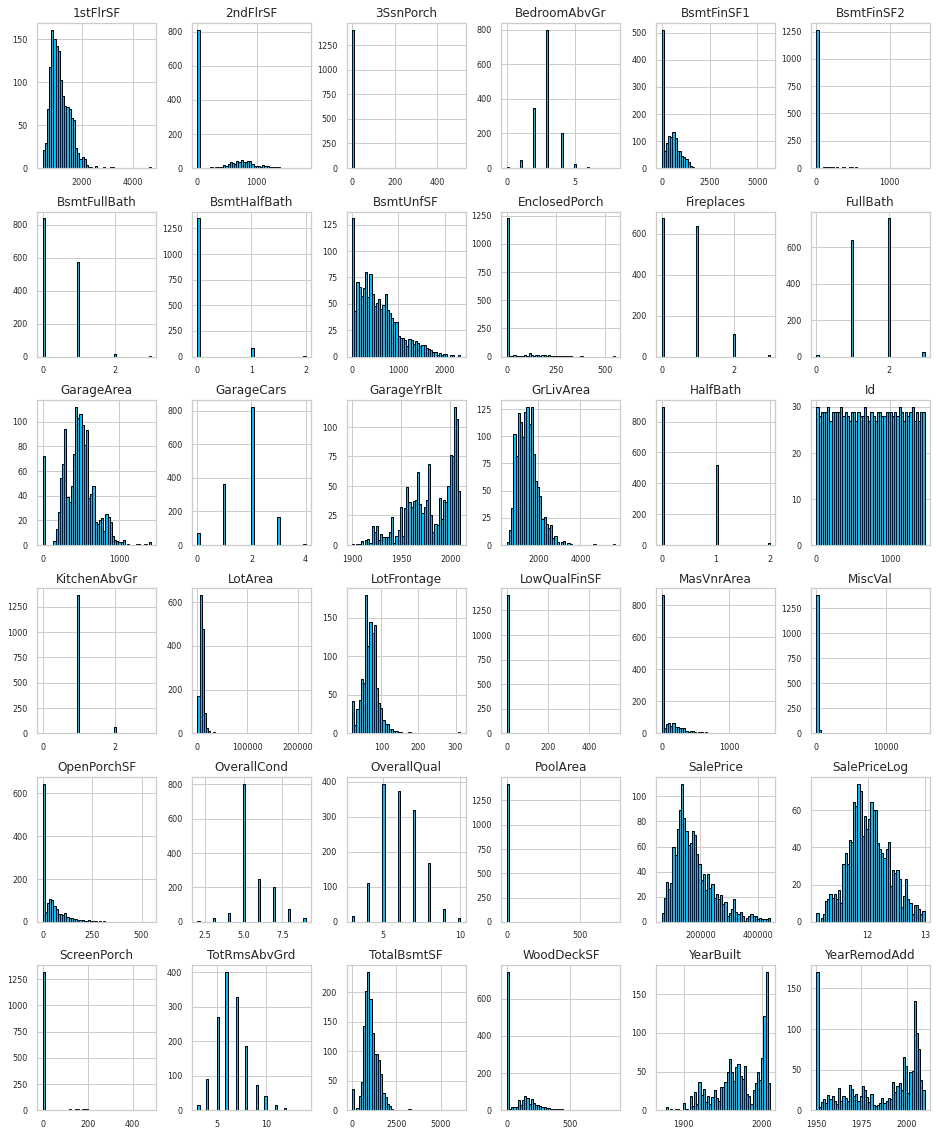

In [146]:
fig_ = train[numeric_cols].hist(figsize=(16, 20), bins=50, color="deepskyblue",
                         edgecolor="black", xlabelsize=8, ylabelsize=8)

По графикам видно, что довольно много порядковых признаков, так же есть несколько похожих на логонормальные распределения(1stFlrSF, 2ndFlrSF, BsmtFinSF1, BsmtFinSF1, BsmtUnfSF, GarageArea, GrLivArea, LotArea, LotFrontage, MasVnrArea, OpenPorchSF, TotalBsmtSF ). Так, чтобы какой то признак напоминал нормальное распределение - такого нет. Позже, после корреляционного анализа, нам может пригодиться знание распределений признаков, чтоб в случае сильного влияния на целевую попробовать привести к нормальному


посмотрм на описательные статистики

In [147]:
train.describe()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,SalePriceLog
count,1428.000000,1171.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1421.000000,1428.000000,1428.000000,...,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000
mean,728.976891,69.843723,10461.021008,6.097339,5.594538,1971.453081,1984.986695,100.497537,439.764706,46.997199,...,472.980392,94.350140,46.052521,21.942577,3.485994,14.710784,2.432073,41.974790,178571.386555,12.025764
std,422.402779,24.057666,9980.227061,1.311228,1.099862,29.955724,20.476673,172.620187,446.695646,162.304592,...,208.612595,124.845005,64.753563,61.222041,29.639728,54.766188,37.900234,493.196765,68659.936764,0.361850
min,1.000000,21.000000,1300.000000,3.000000,2.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66500.000000,11.104972
25%,360.750000,59.000000,7538.750000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,130000.000000,11.775297
50%,729.500000,70.000000,9468.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,0.000000,...,480.000000,0.000000,24.500000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000,12.001512
75%,1094.250000,80.000000,11515.500000,7.000000,6.000000,2000.000000,2004.000000,163.000000,706.500000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,213000.000000,12.269052
max,1460.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,440000.000000,12.994532


 Видим, что много признаков, у которых много значений 0, найдем их все и выведем % нулевых значений

## Модификация признаков с нулевыми значениями

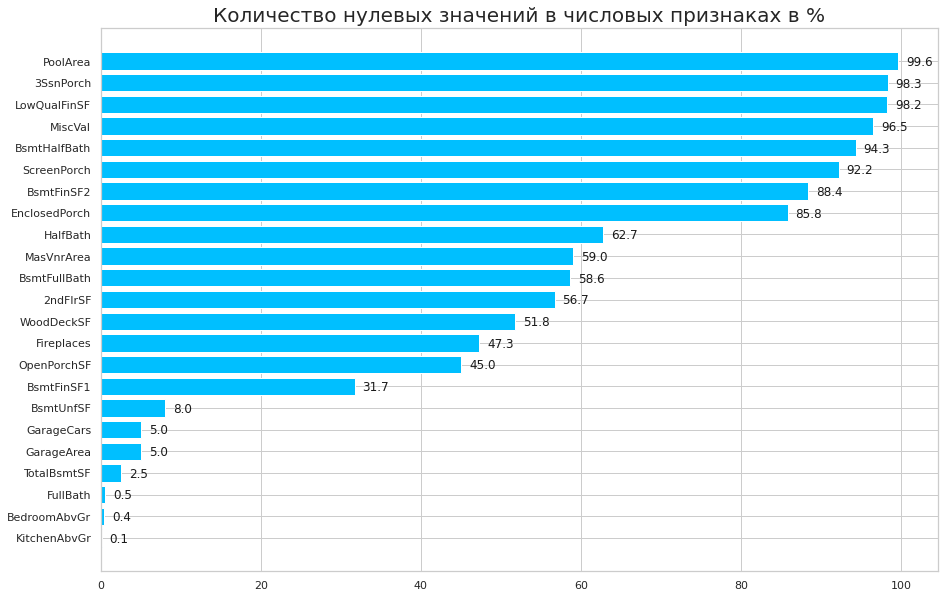

In [148]:
df_0 = (train[numeric_cols]==0).sum()
col_with_0 = round(df_0[df_0>0]/train.shape[0]*100, 1).sort_values()

plt.figure(figsize=(15,10))
plt.barh(y=col_with_0.index, width=col_with_0.values, color="deepskyblue")
plt.title('Количество нулевых значений в числовых признаках в %', fontsize=20)
for i, v in enumerate(col_with_0.values):
    plt.text(v+1, i - .2, str(v), color='k')

График показывает, что у большого числа признаков очень много значений 0, нужно детально разобраться с ними

<b>Удаление числовых признаков, неинформативных с большим количеством 0</b>

пранализируем переменные, в которых есть 0 значения, при этом слабая корреляция с целевой, чтобы разобраться что означает 0

Всего числовых признаков с нулевыми значениями и слабой корреляцией 7


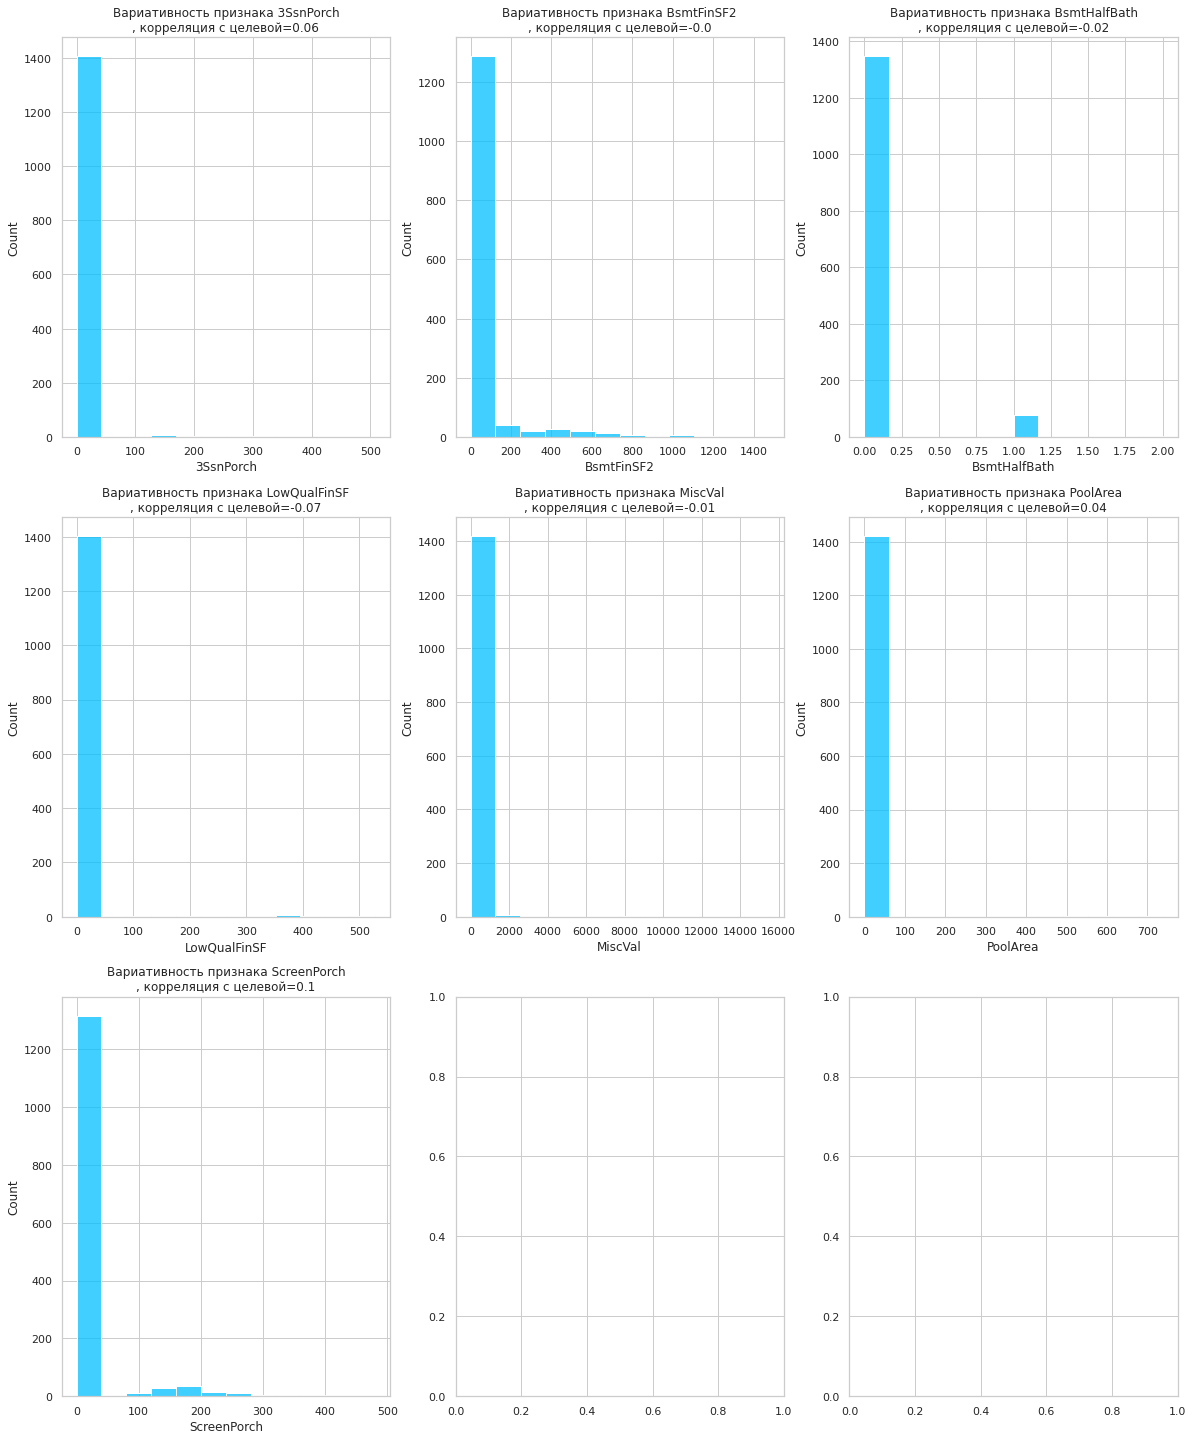

In [149]:

col_int_with_0 = (df_0[df_0>0]/train.shape[0]*100).index
col_int_with_0_low_corr = {}

for col in col_int_with_0:
    corr = train.SalePriceLog.corr(train[col])
    if abs(corr) < TRESHOLD_FOR_CORR:
        col_int_with_0_low_corr[col] = corr
        
fig,axis = plt.subplots(ceil(len(col_int_with_0_low_corr)/3), 3, figsize=(20,25))
y=0

for col, corr in col_int_with_0_low_corr.items():
    i, j = divmod(y, 3)
    sns.histplot(data=train, x=col, ax=axis[i,j], color="deepskyblue")
    axis[i,j].set_title('Вариативность признака ' + col + '\n, корреляция с целевой=' + str(round(corr,2)))
    y += 1

    
print('Всего числовых признаков с нулевыми значениями и слабой корреляцией', len(col_int_with_0_low_corr))

По графикам видим, что почти всегда 0 и при этом это скорее указывает на отсутствующие данные, а не на значения, плюс слабая корреляция с целевой. Все эти признаки малоинформативны и их можно удалить

In [150]:
col_int_for_del = list(col_int_with_0_low_corr.keys())
train.drop(columns=col_int_for_del, axis=1, inplace=True)
test.drop(columns=col_int_for_del, axis=1, inplace=True)

In [151]:
#так же удаляем из массива с числовыми переменными
numeric_cols = del_from_list(numeric_cols, col_int_for_del)


## Модификация признаков с NaN

In [152]:
col_new_int = train[numeric_cols].isna().sum()
col_int_with_na = col_new_int[col_new_int>0].index.to_list()
col_int_with_na

['GarageYrBlt', 'LotFrontage', 'MasVnrArea']

In [153]:
train[col_int_with_na].isna().sum()

GarageYrBlt     72
LotFrontage    257
MasVnrArea       7
dtype: int64

Построим график процентого соотношения отсутствующих данных в данных колонках

Text(0, 0.5, 'Признак\n')

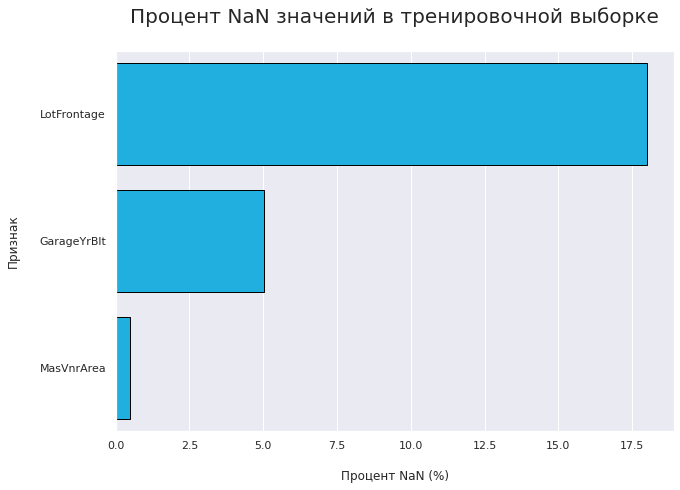

In [154]:
column_name = []
percent_nan = []
for i in col_int_with_na:
    column_name.append(i)
    percent_nan.append(
        round(train[i].isna().sum()*100/len(train[i]), 2))
 
tab = pd.DataFrame({"Column": column_name, "Percent_NaN": percent_nan})
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


sns.set(rc={"figure.figsize": (10, 7)})
#sns.set_style("whitegrid")

p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="deepskyblue")

p.set_title("Процент NaN значений в тренировочной выборке\n", fontsize=20)
p.set_xlabel("\nПроцент NaN (%)")
p.set_ylabel("Признак\n")

Посмотрим графики распределения этих признков, чтоб решить на какое значение заменит

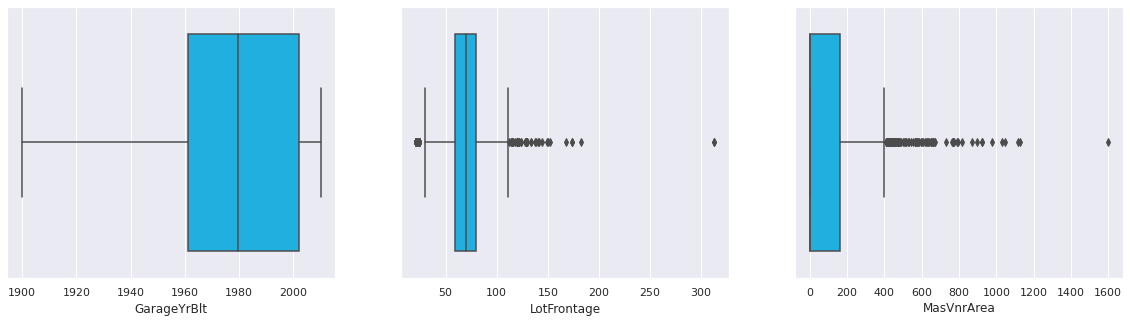

In [155]:
fig,axis = plt.subplots(round(len(col_int_with_na)/3), 3, figsize=(20,5))
for i, col in enumerate(col_int_with_na):
    sns.boxplot(data=train, x=col, ax=axis[i], color="deepskyblue")

Для первого признака возьмем на место отсутствующих среднее, в отстальных - медиану. Первый и третий признаки по хорошему, стоит прологарифмировать, логарифмирование будем делать после корреляционного анализа

In [156]:
train_copy_with_na = pd.DataFrame() 

for col in col_int_with_na:
    train_copy_with_na[col] = train[col]
    if col == 'GarageYrBlt':
        train[col].fillna(train[col].mean(), inplace=True)
    else:
        train[col].fillna(train[col].median(), inplace=True)
   

#my_imputer = SimpleImputer(strategy="median")
#df_train_imputed = pd.DataFrame(my_imputer.fit_transform(train['LotFrontage', 'MasVnrArea']))
#df_train_imputed.columns = train.columns


Мы обработали все пустые значения в тренировочной выборке, проверим:

In [157]:
print('Количество нулевых значений в исходной тренировочной выборке:',train.isna().sum().sum())
print('Количество нулевых значений в копии тренировочной выборки:',train_copy_with_na.isna().sum().sum())

Количество нулевых значений в исходной тренировочной выборке: 0
Количество нулевых значений в копии тренировочной выборки: 336


<b>после замены отстутсвующих значений, проверим распределение измененных признаков и распределение их первоначальных значений</b>

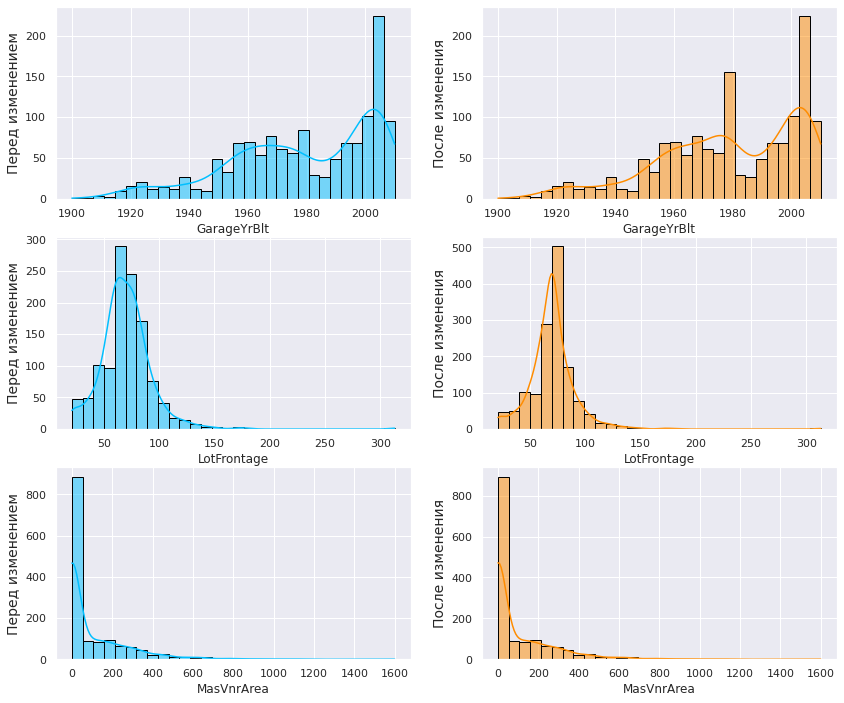

In [158]:
sns.set(rc={"figure.figsize": (14, 12)})
fig, axes = plt.subplots(len(col_int_with_na), 2)
for fig_pos, feature in enumerate(col_int_with_na):

    # до изменений
    p = sns.histplot(ax=axes[fig_pos, 0], x=train_copy_with_na[feature],
                     kde=True, bins=30, color="deepskyblue", edgecolor="black")
    p.set_ylabel(f"Перед изменением", fontsize=14)

    # после изменений
    q = sns.histplot(ax=axes[fig_pos, 1], x=train[feature],
                     kde=True, bins=30, color="darkorange", edgecolor="black")
    q.set_ylabel(f"После изменения", fontsize=14)

Для "LotFrontage" и "GarageYrBlt" распределения изменились после замены. Однако распределение остается прежним для "MasVnrArea". Таким образом, чтобы избежать любой ошибки, связанной с изменениями, сохраняем только признак "MasVnrArea" для своих анализов.

In [159]:
col_int_nan_for_del = ['LotFrontage', 'GarageYrBlt']
train.drop(columns=col_int_nan_for_del, axis=1, inplace=True)
test.drop(columns=col_int_nan_for_del, axis=1, inplace=True)
#так же удаляем из массива с числовыми переменными
numeric_cols = del_from_list(numeric_cols, col_int_nan_for_del)

In [160]:
numeric_cols

array(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFullBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces',
       'FullBath', 'GarageArea', 'GarageCars', 'GrLivArea', 'HalfBath',
       'Id', 'KitchenAbvGr', 'LotArea', 'MasVnrArea', 'OpenPorchSF',
       'OverallCond', 'OverallQual', 'SalePrice', 'SalePriceLog',
       'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd'], dtype=object)

## Корреляционный анализ

<AxesSubplot:>

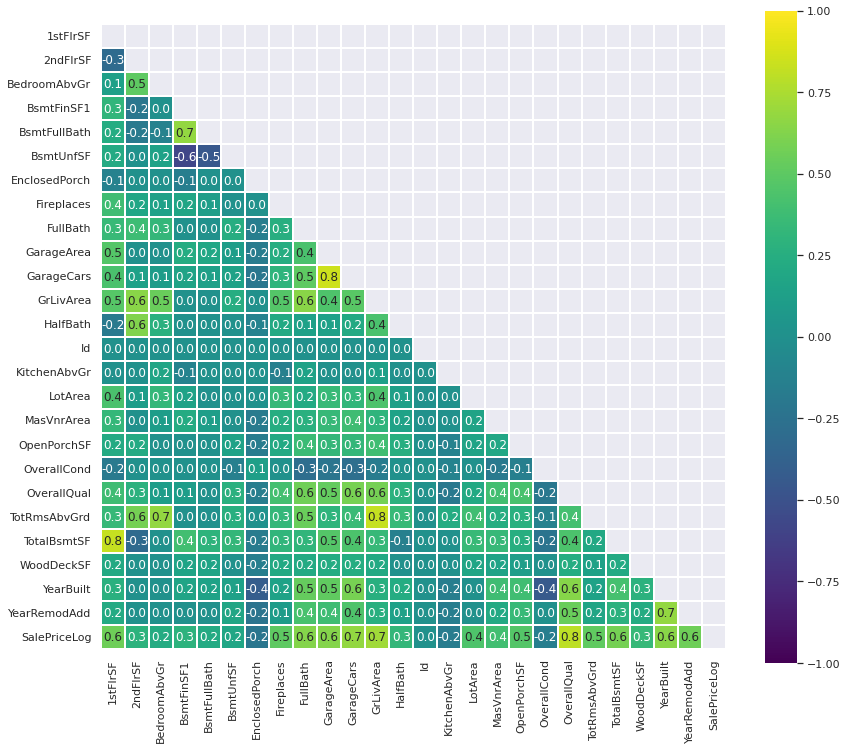

In [161]:
train_num_corr = train[[col for col in numeric_cols if (col!='SalePrice' and col!='SalePriceLog')]]
train_num_corr = train_num_corr.join(train.SalePriceLog) #чтобы целевая была в конце

#в п.6.1 мы видели, что признаки распределены не нормально, поэтому используем непараметрическую корреляцию Спирмана
corr_matrix = train_num_corr.corr(method='spearman')
#для лучшей визуализации обнуляем корреляции, которые ниже заданного порога
corr_matrix[abs(corr_matrix) <= TRESHOLD_FOR_CORR] = 0
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = "viridis"

sns.heatmap(corr_matrix,  mask=mask, linewidths=0.1, vmax=1.0, vmin=-1.0,  square=True, cmap=cmap, 
            annot=True, fmt=".1f")


по графику видим, что у нас есть как плохо коррелируемые признаки числовые, так и хорошо, а так же есть сильные корреляции между признаками

### Анализ корреляции с целевой

**колонки числовые, которые нужно удалить из за слабой корреляции**

In [162]:
corr = train_num_corr.corrwith(train_num_corr.SalePriceLog, method='spearman')
cols_low_corr_target_num = corr[abs(corr) < TRESHOLD_FOR_CORR].index.to_list()
#колонки с числовыми признаками, которые следует удалить ввиду слабой корреляции с целевой
cols_low_corr_target = cols_low_corr_target_num
print(cols_low_corr_target_num)

['Id']


Порог отсечения мы взяли очень низкий. поэтому только идентификатор попал в него

**колонки числовые с сильной корреляцией с целевой - надо их изучить на выбросы**

In [163]:
cols_high_corr_target = corr[abs(corr)>=TRESHOLD_FOR_HIGH_CORR].index.to_list()
cols_high_corr_target = [el for el in cols_high_corr_target if el!='SalePriceLog']
print(cols_high_corr_target)

['FullBath', 'GarageArea', 'GarageCars', 'GrLivArea', 'OverallQual', 'YearBuilt']


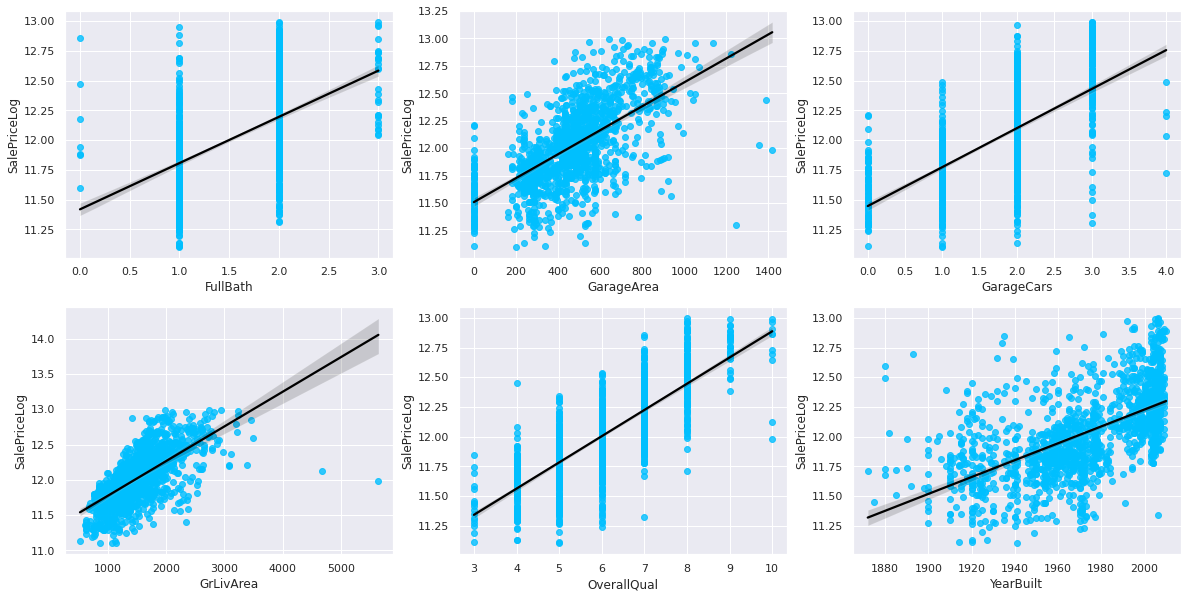

In [164]:
fig,axis = plt.subplots(ceil(len(cols_high_corr_target)/3), 3, figsize=(20,10))
for y, col in enumerate(cols_high_corr_target):
    i, j = divmod(y, 3) 
    sns.regplot(x=train[col], y=train.SalePriceLog, ax=axis[i, j],  scatter_kws={ "color": "deepskyblue"}, \
                line_kws={"color": "black"})
    

По графикам зависимости целевой от признаков видим, что у GarageArea, GrLivArea и OverallQual имеются выбросы, их лучше исключить из выборки, чтоб не вносили шум

In [165]:
outliers1 = train[(train["GrLivArea"] > 4000) & (
    train["SalePriceLog"] <= 12.5)].index.to_list()
outliers1

[523, 1298]

In [166]:
outliers2 = train[(train['GarageArea'] > 1200) & (train['SalePriceLog'] < 12.5)].index.to_list()
outliers2

[581, 1061, 1190, 1298]

In [167]:
outliers3 = train[(train['OverallQual'] == 10) & (train['SalePriceLog'] < 12.25)].index.to_list()
outliers3

[523, 1298]

In [168]:
#объединяем в один массив индексы, замечаем, что есть прям явные отклонения сразу по нескольким признакам
outliers = list(set(outliers1 + outliers2 + outliers3))
outliers
train.shape

(1428, 64)

**удаляем выбросы**

In [169]:
train = train.drop(outliers)

### Анализ корреляций между признаками

In [170]:
#TRESHOLD_FOR_HIGH_CORR_BETWEEN_FEATURE
coll_corr = {}
corr_all = train_num_corr.loc[:, train_num_corr.columns != 'SalePriceLog'].corr()
corr_all.loc[:,:] =  np.tril(corr_all, k=-1) 
for col in corr_all.columns:
    
    coll_corr[col] = corr_all[corr_all[col]>TRESHOLD_FOR_HIGH_CORR_BETWEEN_FEATURE].index.to_list()
  
col_for_del = []
for col, col_array in coll_corr.items():
    if len(col_array):
        print(col,':',col_array)
    col_for_del.extend(col_array)
    
col_for_del = list(set(col_for_del))
print('\nЧисловые признаки, которые следует удалить из выборки всвязи с высокой корреляцией с другими признаками:') 
print(col_for_del if len(col_for_del) else 'таких нет')

1stFlrSF : ['TotalBsmtSF']
GarageArea : ['GarageCars']
GrLivArea : ['TotRmsAbvGrd']

Числовые признаки, которые следует удалить из выборки всвязи с высокой корреляцией с другими признаками:
['GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd']


In [171]:
cols_low_corr_target.extend(col_for_del)
cols_low_corr_target = list(set(cols_low_corr_target))
print('Признаки, которые следует удалить либо из за низкой корреляции с целевой, либо из за высокой с другими признаками:')
print(cols_low_corr_target)

Признаки, которые следует удалить либо из за низкой корреляции с целевой, либо из за высокой с другими признаками:
['GarageCars', 'Id', 'TotalBsmtSF', 'TotRmsAbvGrd']


**удаляем признаки из за корреляции из тренировочной выборки**

In [172]:
train.drop(columns=cols_low_corr_target, axis=1, inplace=True)
test.drop(columns=cols_low_corr_target, axis=1, inplace=True)
#так же удаляем из массива с числовыми переменными
numeric_cols = del_from_list(numeric_cols, cols_low_corr_target)

In [173]:
#train.head()
#train.columns

## Модификация тестовой выборки

In [174]:
test_with_na = test.isna().sum()
col_test_na = test_with_na[test_with_na>0].index.to_list()
col_test_na


['MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'BsmtFullBath', 'GarageArea']

In [175]:
test.fillna({'MasVnrArea': test.MasVnrArea.median()}, inplace=True)

col_test_na = [x for x in col_test_na if x not in ['MasVnrArea']]
test[col_test_na].isna().sum().sort_values()

BsmtFinSF1      1
BsmtUnfSF       1
GarageArea      1
BsmtFullBath    2
dtype: int64

построим графики распределения оставшихся признаков с пустыми значениями

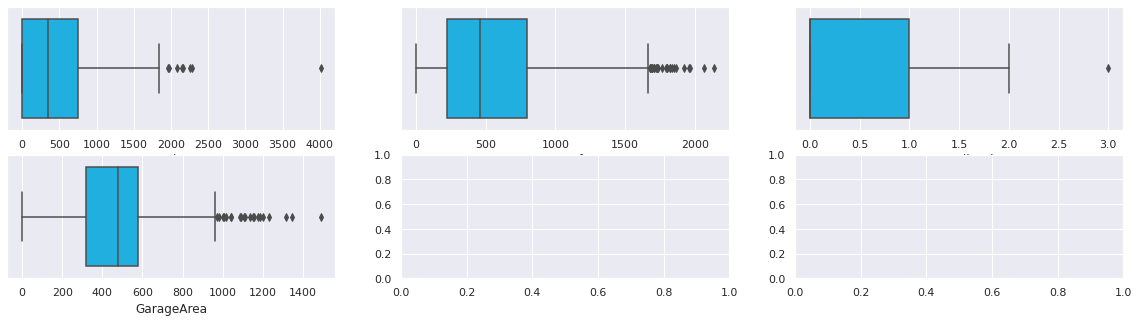

In [176]:
fig,axis = plt.subplots(ceil(len(col_test_na)/3), 3, figsize=(20,5))
for y, col in enumerate(col_test_na):
    i, j = divmod(y, 3)
    #axis[i].boxplot(test[col])
    sns.boxplot(data=test, x=col, ax=axis[i, j], color="deepskyblue")

во всех переменных есть выбросы, поэтому заменим пропущенные на медиану

In [177]:
test[col_test_na] = test[col_test_na].fillna(test[col_test_na].median().iloc[0]) 

Т.к. изначально пропущенных значений было очень мало, замена не должна была внести сильные изменения в распределение признаков с пропущенными значениями, поэтому проверять по графикам распределения не станем.

Проверим, остались ли пропущенные значения в тестовой выборке

In [178]:
test.isna().sum().sum()

0

<b>Мы обработали все недостающие значения и в тестовой, и в тренировочной выборках</b>

## Окончательный вид выборки

**выведем окончательный вид тренировочной выборки, а так же проверим, чтобы форма ее совпадала с тестовой**

In [179]:
train.head()

,MSSubClass,MSZoning,LotArea,Alley,LotShape,LotConfig,Neighborhood,Condition1,Condition2,BldgType,...,EnclosedPorch,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePriceLog
0,60,RL,8450,ismissing,Reg,Inside,CollgCr,Norm,Norm,1Fam,...,0,ismissing,ismissing,ismissing,2,2008,WD,Normal,208500,12.247699
1,20,RL,9600,ismissing,Reg,FR2,Veenker,Feedr,Norm,1Fam,...,0,ismissing,ismissing,ismissing,5,2007,WD,Normal,181500,12.109016
2,60,RL,11250,ismissing,IR1,Inside,CollgCr,Norm,Norm,1Fam,...,0,ismissing,ismissing,ismissing,9,2008,WD,Normal,223500,12.317171
3,70,RL,9550,ismissing,IR1,Corner,Crawfor,Norm,Norm,1Fam,...,272,ismissing,ismissing,ismissing,2,2006,WD,Abnorml,140000,11.849405
4,60,RL,14260,ismissing,IR1,FR2,NoRidge,Norm,Norm,1Fam,...,0,ismissing,ismissing,ismissing,12,2008,WD,Normal,250000,12.429220


In [180]:
print('форма тренировочной выборки: ', train.shape)
print('форма тестовой выборки: ', test.shape)

форма тренировочной выборки:  (1423, 60)
форма тестовой выборки:  (1459, 58)


Число колонок в тренировоччной меньше, тк там нет целевых признаков исходного и логарифмированного. Позднее, перед построением моделей, мы еще проверим более тщательно именно на совпадение признаков тренировочной и тестовой выборок, а не просто форму, но это после всех преобразований.

# Feature engineering

In [181]:
#выведем все оставшиеся признаки:
print(train.columns.to_list())

['MSSubClass', 'MSZoning', 'LotArea', 'Alley', 'LotShape', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageArea', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'SalePriceLog']


Преобразуем год постройки и год реконструкции на "возраст" (сколько лет прошло)

In [182]:

train["AgeSinceConst"] = (
    train["YearBuilt"].max() - train["YearBuilt"])

test["AgeSinceConst"] = test["YearBuilt"].max() - test["YearBuilt"]

# Удаляем признак Год
train.drop(["YearBuilt"], axis=1, inplace=True)
test.drop(["YearBuilt"], axis=1, inplace=True)

In [183]:
train["AgeSinceRemod"] = (
    train["YearRemodAdd"].max() - train["YearRemodAdd"])

test["AgeSinceRemod"] = test["YearRemodAdd"].max() - test["YearRemodAdd"]

# Удаляем признак Год Реконструкии
train.drop(["YearRemodAdd"], axis=1, inplace=True)
test.drop(["YearRemodAdd"], axis=1, inplace=True)

Прологарифмируем признаки, у которых распределение похоже на логнормальное(см. п. 6.1) и построим графики новых распределений. Сюда же добавим новые признаки "возраст", тк стоимость логарифмически зависит от нее (чем меньше возраст - тем сильнее отличия в цене):

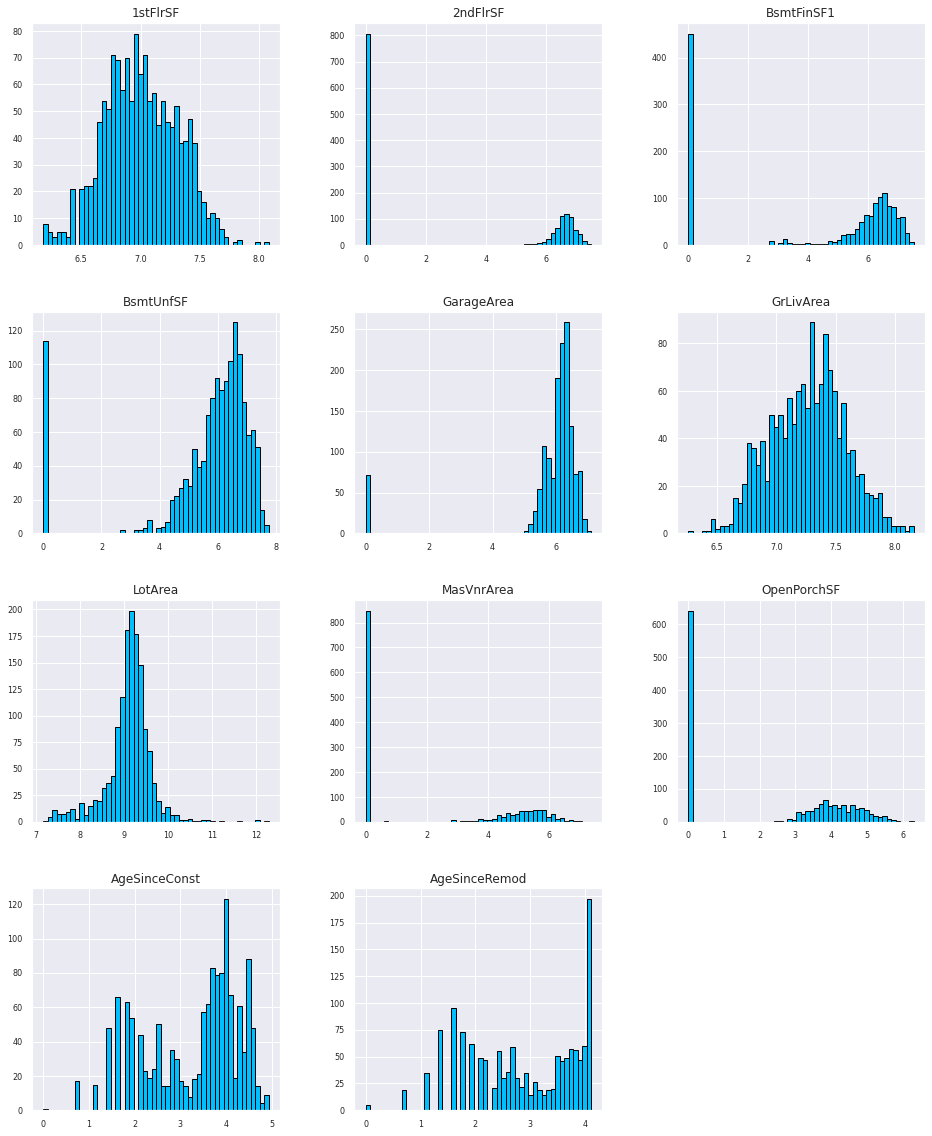

In [184]:
col_for_log = ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'LotArea',\
               'MasVnrArea', 'OpenPorchSF', 'AgeSinceConst', 'AgeSinceRemod'] 
for col in col_for_log:
    train[col] = np.log(train[col] + 1)
    test[col] = np.log(test[col] + 1)
    
fig_ = train[col_for_log].hist(figsize=(16, 20), bins=50, color="deepskyblue",
                         edgecolor="black", xlabelsize=8, ylabelsize=8)

# Продготовка данных к моделированию

## Разделение тренировочной выборки на признаки и целевую переменную

In [185]:
X_train = train.drop(columns=['SalePrice', 'SalePriceLog'], axis=1)
y_train = train['SalePriceLog']

X_test = test

In [187]:
print('количество пропущенных значений в тренировочной:', X_train.isna().sum().sum())
print('количество пропущенных значений в тестовой:', test.isna().sum().sum())

количество пропущенных значений в тренировочной: 0
количество пропущенных значений в тестовой: 0


## Нормализация  числовых признаков

In [188]:
#отбираем числовые признаки
train_numeric = X_train.select_dtypes(include=[np.number])
numeric_cols = train_numeric.columns.values
print(numeric_cols)

['LotArea' 'OverallQual' 'OverallCond' 'MasVnrArea' 'BsmtFinSF1'
 'BsmtUnfSF' '1stFlrSF' '2ndFlrSF' 'GrLivArea' 'BsmtFullBath' 'FullBath'
 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'Fireplaces' 'GarageArea'
 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' 'AgeSinceConst'
 'AgeSinceRemod']


In [189]:
X_train[numeric_cols].head()

,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,AgeSinceConst,AgeSinceRemod
0,9.042040,7,5,5.283204,6.561031,5.017280,6.753438,6.751101,7.444833,1,...,1,3,1,0,6.308098,0,4.127134,0,2.079442,2.079442
1,9.169623,6,8,0.000000,6.886532,5.652489,7.141245,0.000000,7.141245,0,...,0,3,1,1,6.133398,298,0.000000,0,3.555348,3.555348
2,9.328212,7,5,5.093750,6.188264,6.075346,6.825460,6.765039,7.488294,1,...,1,3,1,1,6.411818,0,3.761200,0,2.302585,2.197225
3,9.164401,7,5,0.000000,5.379897,6.293419,6.869014,6.629363,7.448916,1,...,0,3,1,1,6.466145,0,3.583519,272,4.564348,3.713572
4,9.565284,8,5,5.860786,6.486161,6.196444,7.044033,6.960348,7.695758,1,...,1,4,1,1,6.729824,192,4.442651,0,2.397895,2.397895


In [190]:
sc = StandardScaler()

X_train[numeric_cols] = sc.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = sc.transform(X_test[numeric_cols])
X_train[numeric_cols].head()

,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,AgeSinceConst,AgeSinceRemod
0,-0.119746,0.696720,-0.543943,1.216488,0.779941,-0.341902,-0.828317,1.181753,0.565040,1.111375,...,1.231651,0.156534,-0.212522,-0.952802,0.342278,-0.755279,0.853139,-0.359246,-1.136416,-0.782630
1,0.130456,-0.072429,2.184721,-0.805937,0.889278,0.002086,0.446458,-0.871441,-0.395822,-0.819622,...,-0.757724,0.156534,-0.212522,0.614640,0.216885,1.637166,-1.071091,-0.359246,0.282496,0.715473
2,0.441467,0.696720,-0.543943,1.143965,0.654727,0.231078,-0.591571,1.185992,0.702593,1.111375,...,1.231651,0.156534,-0.212522,0.614640,0.416724,-0.755279,0.682526,-0.359246,-0.921890,-0.663076
3,0.120217,0.696720,-0.543943,-0.805937,0.383193,0.349172,-0.448401,1.144730,0.577963,1.111375,...,-0.757724,0.156534,-0.212522,0.614640,0.455717,-0.755279,0.599685,4.078370,1.252533,0.876077
4,0.906388,1.465869,-0.543943,1.437589,0.754792,0.296656,0.126908,1.245391,1.359222,1.111375,...,1.231651,1.394021,-0.212522,0.614640,0.644976,0.786162,1.000245,-0.359246,-0.830260,-0.459387


## Кодирование категориальных признаков

In [191]:
#отбираем категориальные признаки
train_non_numeric = X_train.select_dtypes(exclude=[np.number])
non_numeric_cols = train_non_numeric.columns.values
print(non_numeric_cols)

['MSSubClass' 'MSZoning' 'Alley' 'LotShape' 'LotConfig' 'Neighborhood'
 'Condition1' 'Condition2' 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl'
 'Exterior2nd' 'MasVnrType' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond'
 'BsmtExposure' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical'
 'KitchenQual' 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish'
 'GarageCond' 'PavedDrive' 'PoolQC' 'Fence' 'MiscFeature' 'MoSold'
 'YrSold' 'SaleType' 'SaleCondition']


чтобы преобразовать категориальные признаки к дамми-переменным, нужно для начала объединить тренировочную выборку с тестовой, чтоб не получилось так, что в одной одни колонки, в другой - другие. А после уже снова разбить на тренировочную и тестовую

In [192]:
#запоминаем длину тренировочной - чтобы потом ее извлечь из объединенной
len_train = X_train.shape[0]
len_train

1423

In [193]:
#объединяем
X_all = X_train.append(X_test) 
X_all.shape

(2882, 58)

In [194]:
X_all = pd.get_dummies(X_all, columns=non_numeric_cols)
X_all.head()

,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.119746,0.696720,-0.543943,1.216488,0.779941,-0.341902,-0.828317,1.181753,0.565040,1.111375,...,0,0,0,1,0,0,0,0,1,0
1,0.130456,-0.072429,2.184721,-0.805937,0.889278,0.002086,0.446458,-0.871441,-0.395822,-0.819622,...,0,0,0,1,0,0,0,0,1,0
2,0.441467,0.696720,-0.543943,1.143965,0.654727,0.231078,-0.591571,1.185992,0.702593,1.111375,...,0,0,0,1,0,0,0,0,1,0
3,0.120217,0.696720,-0.543943,-0.805937,0.383193,0.349172,-0.448401,1.144730,0.577963,1.111375,...,0,0,0,1,1,0,0,0,0,0
4,0.906388,1.465869,-0.543943,1.437589,0.754792,0.296656,0.126908,1.245391,1.359222,1.111375,...,0,0,0,1,0,0,0,0,1,0


In [195]:
#разделяем назад на тренировочную и тестовую выборки
X_train = X_all[:len_train]
X_test = X_all[len_train:]
X_test.head()

,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.505259,-0.841578,0.365612,-0.805937,0.642076,-0.025192,-0.678365,-0.871441,-1.478858,-0.819622,...,0,0,0,1,0,0,0,0,1,0
1,0.907350,-0.072429,0.365612,0.989924,0.869857,0.195048,0.616367,-0.871441,-0.232225,-0.819622,...,0,0,0,1,0,0,0,0,1,0
2,0.846346,-0.841578,-0.543943,-0.805937,0.818077,-0.390655,-0.563141,1.121789,0.411543,-0.819622,...,0,0,0,1,0,0,0,0,1,0
3,0.206185,-0.072429,0.365612,0.359515,0.726494,0.073209,-0.570226,1.111658,0.362624,-0.819622,...,0,0,0,1,0,0,0,0,1,0
4,-1.146671,1.465869,-0.543943,-0.805937,0.449048,0.691517,0.492974,-0.871441,-0.351033,-0.819622,...,0,0,0,1,0,0,0,0,1,0


Перед построением моделей проверим, что тестовая и тренировочная выборки состоят из одинаковых признаков:

In [196]:
col_in_train_notin_test = [col for col in X_train.columns if col not in X_test.columns]
col_in_test_notin_train = [col for col in X_test.columns if col not in X_train.columns]
print('Признаки, которые есть в тренировочной, но которых нет в тестовой: ', col_in_train_notin_test)
print('Признаки, которые есть в тестовой, но которых нет в тренировочной: ', col_in_test_notin_train)

Признаки, которые есть в тренировочной, но которых нет в тестовой:  []
Признаки, которые есть в тестовой, но которых нет в тренировочной:  []


## Регрессия обратного исключения

In [197]:
Будем постепенно уменьшать признаки и следить за влиянием на качество модели 
Используем простую регрессию OLS

SyntaxError: invalid syntax (3346390767.py, line 1)

In [198]:
Selected_Features = []

def backward_regression(X, y, alpha=0.05, verbose=True):
    included = list(X.columns)
    while True:
        changed = False
        X = sm.add_constant((X[included]))
        model = sm.OLS(y, X).fit()
        
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        
        if worst_pval > alpha:
            changed = True
            worst_feature = pvalues.idxmax()#.loc[0]
            included.remove(worst_feature)
            if verbose:
                print(f"Наименее важный признак : {worst_feature}, {worst_pval} ")
        if not changed:
            break

    #print(f"\nОтобранные признаки:\n{included}")
    return included
    
Selected_Features = backward_regression(X_train, y_train)
print('Всего оставшихся признаков:', len(Selected_Features))

Наименее важный признак : Exterior2nd_CBlock, 0.9017315964622418 
Наименее важный признак : Exterior2nd_Other, 0.7622043503583943 
Наименее важный признак : Exterior2nd_AsphShn, 0.7777296696475184 
Наименее важный признак : MSSubClass_40, 0.7575184774756447 
Наименее важный признак : MSSubClass_45, 0.9494974819813957 
Наименее важный признак : BedroomAbvGr, 0.7189663754435043 
Наименее важный признак : Neighborhood_Mitchel, 0.6918496173457966 
Наименее важный признак : Neighborhood_NWAmes, 0.6759007953457776 
Наименее важный признак : MSSubClass_150, 0.8749255868075158 
Наименее важный признак : Neighborhood_NAmes, 0.6358759438022037 
Наименее важный признак : Neighborhood_Gilbert, 0.63985953267311 
Наименее важный признак : MSSubClass_190, 0.6321334456220384 
Наименее важный признак : Neighborhood_Blmngtn, 0.6209670676536162 
Наименее важный признак : OpenPorchSF, 0.6179578791848741 
Наименее важный признак : MasVnrArea, 0.6241483987921215 
Наименее важный признак : Exterior2nd_Stone,

Оставим только отобранные регрессией обратного исключения признаки

In [199]:
X_train = X_train.loc[:, Selected_Features]
X_test = X_test.loc[:, Selected_Features]

## Расстояние Кука

Вычисляя расстояние Кука, мы можем обнаружить влиятельные наблюдения в регрессионной модели. Это расстояние обнаруживает данные с большими остатками (выбросами), которые могут исказить прогноз и точность регрессии. В адекватной модели все расстояния Кука должны быть примерно одинаковыми; если это не так, то имеются основания считать, что соответствующее наблюдение (или наблюдения) смещает оценки коэффициентов регрессии.


In [200]:
X_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_constant)
lr = model.fit()
#расчитываем влияние
influence = lr.get_influence()
#нахождение расстояния Кука
cooks = influence.cooks_distance

cook_df = pd.DataFrame({"Cook_Distance": cooks[0], "p_value": cooks[1]})
cook_df.head()

,Cook_Distance,p_value
0,1.932239e-07,1.0
1,9.310723e-05,1.0
2,2.124284e-05,1.0
3,3.604114e-03,1.0
4,1.594976e-03,1.0


In [201]:
# удаляем влиятельные наблюдения
influent_observation = cook_df[cook_df["p_value"] < 0.05].index.tolist()
print(f"Влиятельные наблюдения для удаления: {influent_observation}")

# Drop these obsrevations
X_train = X_train.drop(X_train.index[influent_observation])
y_train = y_train.drop(y_train.index[influent_observation])

Влиятельные наблюдения для удаления: [322, 790, 852, 925]


<b>Мы нормировали числовые признаки, преобразовали категориальные, удалили малоинформативные признаки при посощи регрессии обратного шага,удалили наблюдения, похожие на выбросы при помощи расстояния Кука. Теперь можно приступать к прогнозированию, но для начала определимся с моделью</b>

# Моделирование

## Сравнение простых моделей с параметрами по умолчанию для выбора наилучшей модели

Будем рассматривать несколько моделей:
+ Ридж регрессия
* Лассо регрессия
* ElasticNet
* SVR
- Случайный лес

In [204]:
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train,
                                                    y_train,
                                                    test_size=SPLIT_TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [205]:
X_train_train.head()

,LotArea,OverallQual,OverallCond,BsmtFinSF1,1stFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,KitchenAbvGr,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
743,0.707710,-0.841578,0.365612,0.624432,0.934155,0.073757,-0.819622,0.812621,-0.757724,-0.212522,...,0,0,0,1,0,0,0,0,1,0
1027,0.114047,1.465869,-0.543943,1.035726,1.319079,0.444382,1.111375,0.812621,-0.757724,-0.212522,...,0,1,0,0,0,0,0,0,0,1
324,0.445819,0.696720,1.275166,-1.423940,1.787075,2.320074,-0.819622,0.812621,1.231651,-0.212522,...,0,0,0,1,0,0,0,0,1,0
525,-0.353604,0.696720,-0.543943,-1.423940,0.456852,-0.385814,-0.819622,0.812621,-0.757724,-0.212522,...,0,0,0,1,0,0,0,0,1,0
652,-0.051336,0.696720,-0.543943,-1.423940,-0.631067,0.576120,-0.819622,0.812621,1.231651,-0.212522,...,0,0,0,1,0,0,0,0,1,0


In [210]:
models = [Ridge(), Lasso(alpha=0.001), ElasticNet(alpha=0.001), SVR(), RandomForestRegressor()]
scores = dict()
for m in models:
    m.fit(X_train_train, y_train_train)
    y_pred = m.predict(X_train_test)
    
    
    print(f'model: {str(m)}')
    print(f'RMSE: {round(np.sqrt(mean_squared_error(exp(y_train_test), exp(y_pred))), 3)}')
    print(f'R²: {round(r2_score(exp(y_train_test), exp(y_pred)), 3)}')
    print('-'*30, '\n')

model: Ridge()
RMSE: 21256.307
R²: 0.897
------------------------------ 

model: Lasso(alpha=0.001)
RMSE: 21199.968
R²: 0.897
------------------------------ 

model: ElasticNet(alpha=0.001)
RMSE: 20995.373
R²: 0.899
------------------------------ 

model: SVR()
RMSE: 21992.611
R²: 0.889
------------------------------ 

model: RandomForestRegressor()
RMSE: 25295.228
R²: 0.854
------------------------------ 



Выберем Ридж регрессию для дальнейшей работы

## Подбор параметров и предсказание с ипользованием Ридж регрессии

In [214]:
parameters_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}


In [215]:
model = Ridge()

ridge_cv = GridSearchCV(model,
                       parameters_grid,
                       cv=NUM_SPLIT_FOR_GRID,
                       n_jobs=-1)

ridge_cv.fit(X_train_train, y_train_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]})

In [216]:
print(f"Лучшие параметры: {ridge_cv.best_params_}")
print(f"Лучший R² (train): {ridge_cv.best_score_}")

Лучшие параметры: {'alpha': 10}
Лучший R² (train): 0.9204822567295166


In [221]:
parameters_grid = {
    'alpha': [5, 15, 25, 50]
}
model = Ridge()

ridge_cv = GridSearchCV(model,
                       parameters_grid,
                       cv=NUM_SPLIT_FOR_GRID,
                       n_jobs=-1)
ridge_cv.fit(X_train_train, y_train_train)
print(f"Лучшие параметры: {ridge_cv.best_params_}")
print(f"Лучший R² (train): {ridge_cv.best_score_}")

Лучшие параметры: {'alpha': 5}
Лучший R² (train): 0.9205056770789712


На основании анализа подбора выберем alpha = 5

In [254]:
ridge_mod = Ridge(alpha=ridge_cv.best_params_["alpha"])

# Fit the model on train set
ridge_mod.fit(X_train_train, y_train_train)

# Predict on test set
y_pred = ridge_mod.predict(X_train_test)

print(f"- {ridge_mod.__class__.__name__}")
print(f'RMSE: {round(np.sqrt(mean_squared_error(exp(y_train_test.values), exp(y_pred))), 3)}')
print(f'R²: {round(r2_score(exp(y_train_test.values), exp(y_pred)), 3)}')


- Ridge
RMSE: 20825.511
R²: 0.901


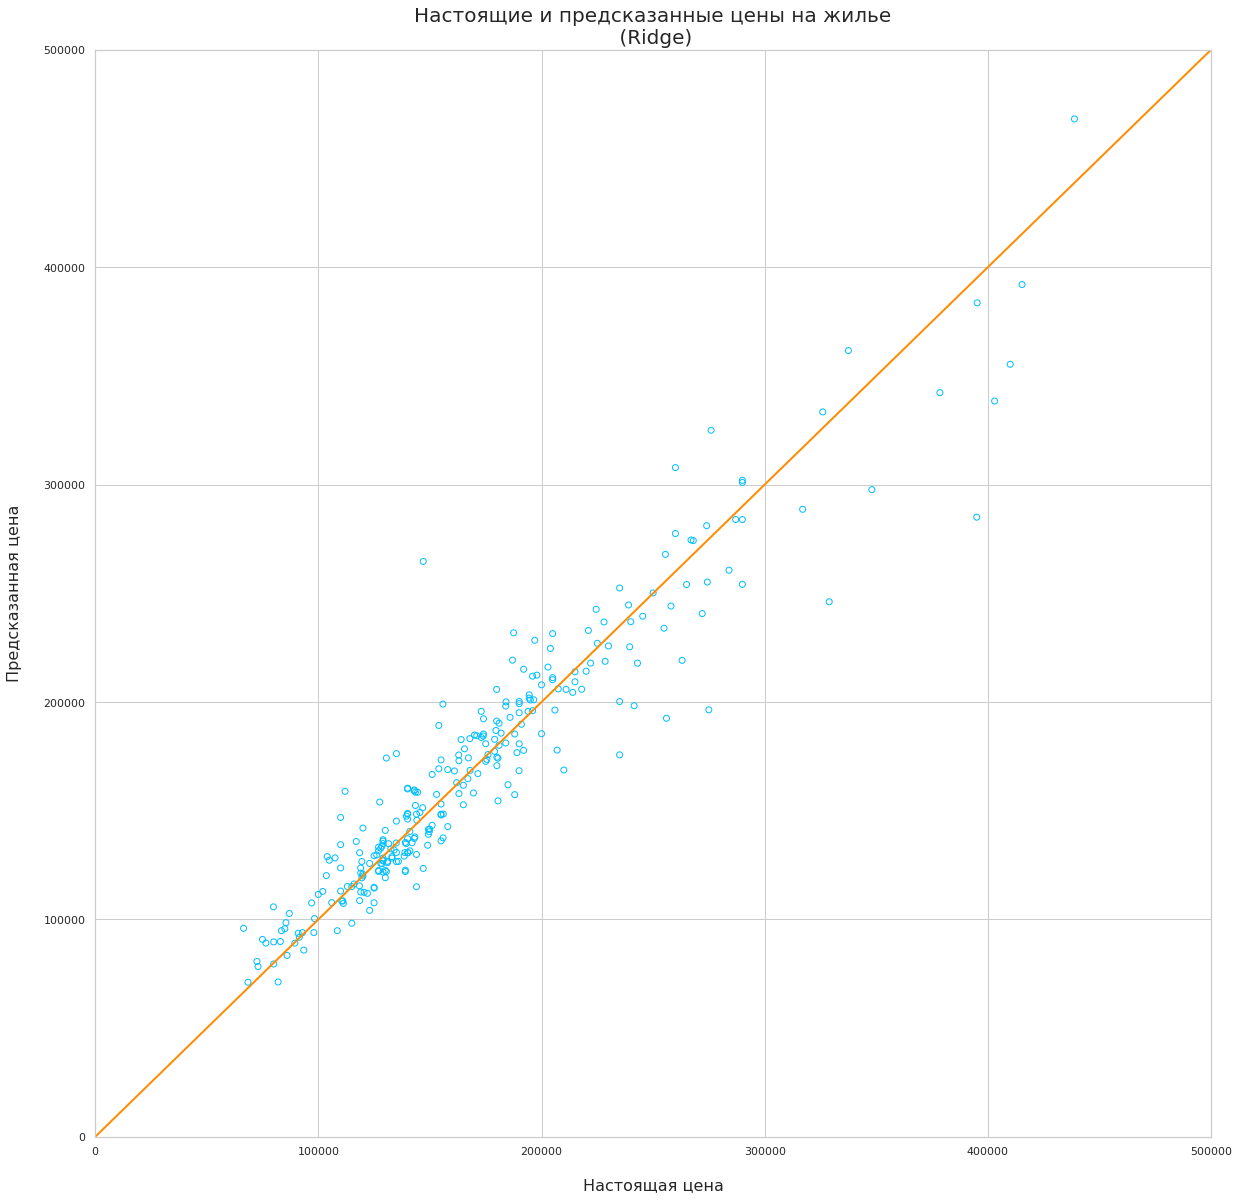

In [256]:
actual_price = exp(y_train_test.values)
predicted_price = exp(y_pred)

plt.figure()
plt.title("Настоящие и предсказанные цены на жилье\n (Ridge)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 500000], [0, 500000], "darkorange", lw=2)
plt.xlim(0, 500000)
plt.ylim(0, 500000)
plt.xlabel("\nНастоящая цена", fontsize=16)
plt.ylabel("Предсказанная цена\n", fontsize=16)
plt.show()

По графику видим, что Ридж регрессия неплохо дает предсказания цены

**выберем за модель Ридж регрессию с alpha=5 и предскажем значения для тестовой выборки**

In [259]:
log_predictions = ridge_mod.predict(X_test)
predictions = exp(log_predictions).round().astype(int)
predictions[:10]

array([119761, 165414, 178343, 199999, 184472, 167236, 174996, 161860,
       204694, 114934])

In [260]:
submission = {
    'Id': test_id,
    'SalePrice': predictions
}
solution = pd.DataFrame(submission)
solution.to_csv('data/submission.csv',index=False)